# Unsupervised surgery pipeline with TRVAE

In [1]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Set relevant anndata.obs labels and training length

Here we use the CelSeq2 and SS2 studies as query data and the other 3 studies as reference atlas. We strongly suggest to use earlystopping to avoid over-fitting. The best earlystopping criteria is the 'val_unweighted_loss' for TRVAE.

In [5]:
condition_key = 'study'
cell_type_key = 'cell_type'
target_conditions = ['Pancreas CelSeq2', 'Pancreas SS2']


trvae_epochs = 500
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

### Download Dataset and split into reference dataset and query dataset

In [6]:
url = 'https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd'
output = 'pancreas.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd
To: C:\Users\sergei.rybakov\projects\notebooks\pancreas.h5ad
126MB [00:35, 3.52MB/s] 


'pancreas.h5ad'

In [7]:
adata_all = sc.read('pancreas.h5ad')

This line makes sure that count data is in the adata.X. Remember that count data in adata.X is necessary when using "nb" or "zinb" loss. However, when using trVAE with MSE loss normalized data is necessary in adata.X

In [8]:
adata = adata_all.raw.to_adata()
adata = remove_sparsity(adata)
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)]
target_adata = adata[adata.obs[condition_key].isin(target_conditions)]
source_conditions = source_adata.obs[condition_key].unique().tolist()

In [9]:
source_adata

View of AnnData object with n_obs × n_vars = 10294 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [10]:
target_adata

View of AnnData object with n_obs × n_vars = 5387 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

### Create TRVAE model and train it on reference dataset

Create the trVAE model instance with NB loss as default. Insert "recon_loss='mse'," or "recon_loss='zinb'," to change the reconstruction loss.

In [11]:
trvae = sca.models.TRVAE(
    adata=source_adata,
    condition_key=condition_key,
    conditions=source_conditions,
    hidden_layer_sizes=[128, 128],
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1000 128 3
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 3
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 



In [12]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs
)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Valid_data 1029
Condition: 0 Counts in TrainData: 821
Condition: 1 Counts in TrainData: 147
Condition: 2 Counts in TrainData: 61
 |████████------------| 40.6%  - epoch_loss:    2387 - epoch_unweighted_loss:    2387 - epoch_recon_loss:    2367 - epoch_kl_loss:      18 - epoch_mmd_loss:       2 - val_loss:    1267 - val_unweighted_loss:    1267 - val_recon_loss:    1248 - val_kl_loss:      13 - val_mmd_loss:       5
ADJUSTED LR
 |█████████-----------| 47.0%  - epoch_loss:    2357 - epoch_unweighted_loss:    2357 - epoch_recon_loss:    2338 - epoch_kl_loss:      17 - epoch_mmd_loss:       2 - val_loss:    1346 - val_unweighted_loss:    1346 - val_recon_loss:    1327 - val_kl_loss:      14 - val_mmd_loss:       5
ADJUSTED LR
 |█████████-----------| 48.4%  - epoch_loss:    2371 - epoch_unweighted_loss:    2371 - epoch_recon_loss:    2352 - epoch_kl_loss:      18 - epoch_mmd_loss:       2 - val_loss:    1302 - val_unweighted_loss:    1302 - val_recon_loss:    1284 - val_kl_loss:      14 - va

### Create anndata file of latent representation and compute UMAP

In [13]:
adata_latent = sc.AnnData(trvae.get_latent())
adata_latent.obs['cell_type'] = source_adata.obs[cell_type_key].tolist()
adata_latent.obs['batch'] = source_adata.obs[condition_key].tolist()

... storing 'cell_type' as categorical
... storing 'batch' as categorical


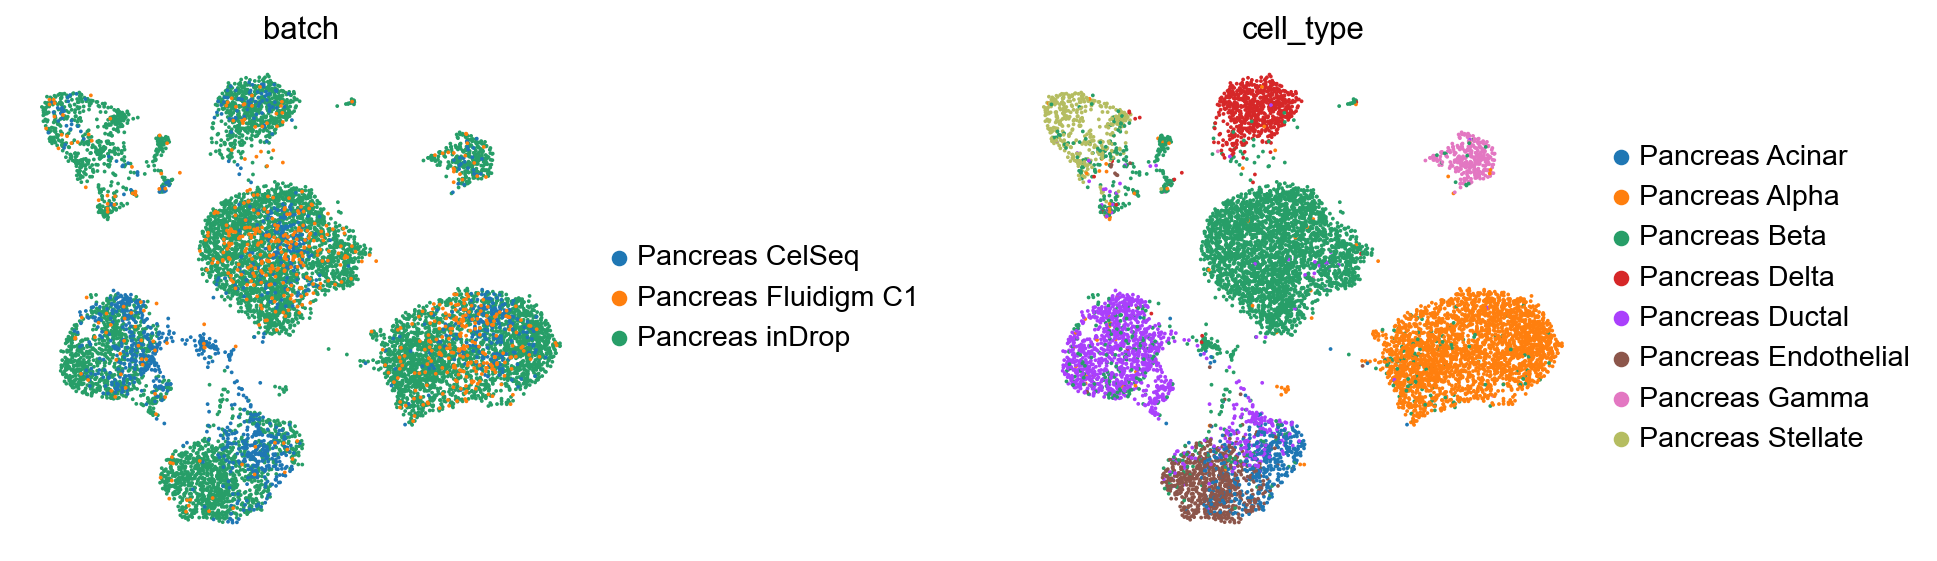

In [14]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

After pretraining the model can be saved for later use

In [15]:
ref_path = 'reference_model/'
trvae.save(ref_path, overwrite=True)

### Perform surgery on reference model and train on query dataset

In [16]:
new_trvae = sca.models.TRVAE.load_query_data(adata=target_adata, reference_model=ref_path)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1000 128 5
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 5
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 



In [17]:
new_trvae.train(
    n_epochs=surgery_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    weight_decay=0
)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Valid_data 538
Condition: 0 Counts in TrainData: 0
Condition: 1 Counts in TrainData: 0
 |████████████--------| 64.0%  - epoch_loss:    2664 - epoch_unweighted_loss:    2664 - epoch_recon_loss:    2647 - epoch_kl_loss:      16 - epoch_mmd_loss:       0 - val_loss:    2606 - val_unweighted_loss:    2606 - val_recon_loss:    2589 - val_kl_loss:      16 - val_mmd_loss:       1
ADJUSTED LR
 |█████████████-------| 68.8%  - epoch_loss:    2576 - epoch_unweighted_loss:    2576 - epoch_recon_loss:    2559 - epoch_kl_loss:      16 - epoch_mmd_loss:       0 - val_loss:    2493 - val_unweighted_loss:    2493 - val_recon_loss:    2477 - val_kl_loss:      16 - val_mmd_loss:       1
ADJUSTED LR
 |██████████████------| 70.2%  - epoch_loss:    2528 - epoch_unweighted_loss:    2528 - epoch_recon_loss:    2512 - epoch_kl_loss:      16 - epoch_mmd_loss:       0 - val_loss:    2495 - val_unweighted_loss:    2495 - val_recon_loss:    2478 - val_kl_loss:      16 - val_mmd_loss:       1
Stopping early: no imp

In [18]:
adata_latent = sc.AnnData(new_trvae.get_latent())
adata_latent.obs['cell_type'] = target_adata.obs[cell_type_key].tolist()
adata_latent.obs['batch'] = target_adata.obs[condition_key].tolist()

... storing 'cell_type' as categorical
... storing 'batch' as categorical


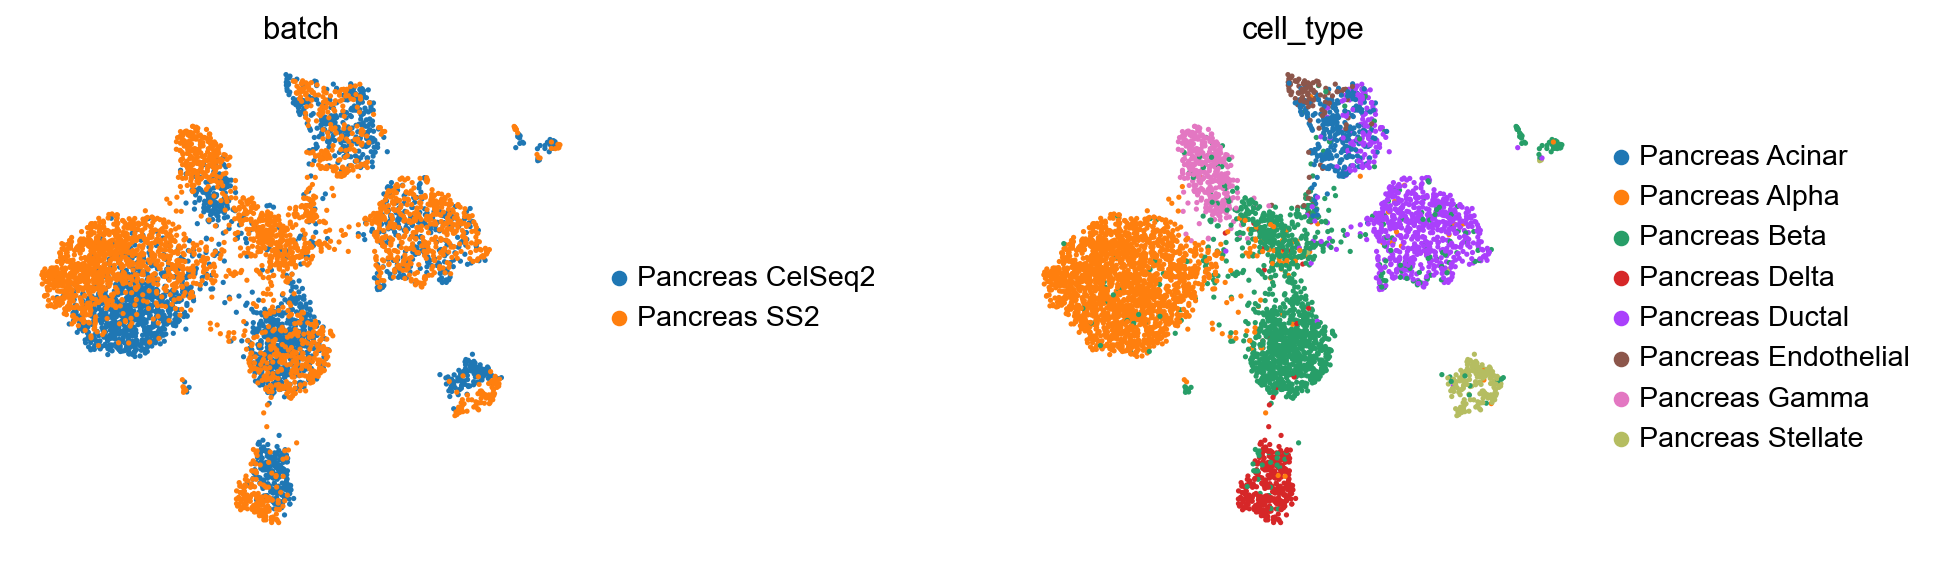

In [19]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [20]:
surg_path = 'surgery_model'
new_trvae.save(surg_path, overwrite=True)

### Get latent representation of reference + query dataset and compute UMAP

In [21]:
full_latent = sc.AnnData(new_trvae.get_latent(adata.X, adata.obs[condition_key]))
full_latent.obs['cell_type'] = adata.obs[cell_type_key].tolist()
full_latent.obs['batch'] = adata.obs[condition_key].tolist()

... storing 'cell_type' as categorical
... storing 'batch' as categorical


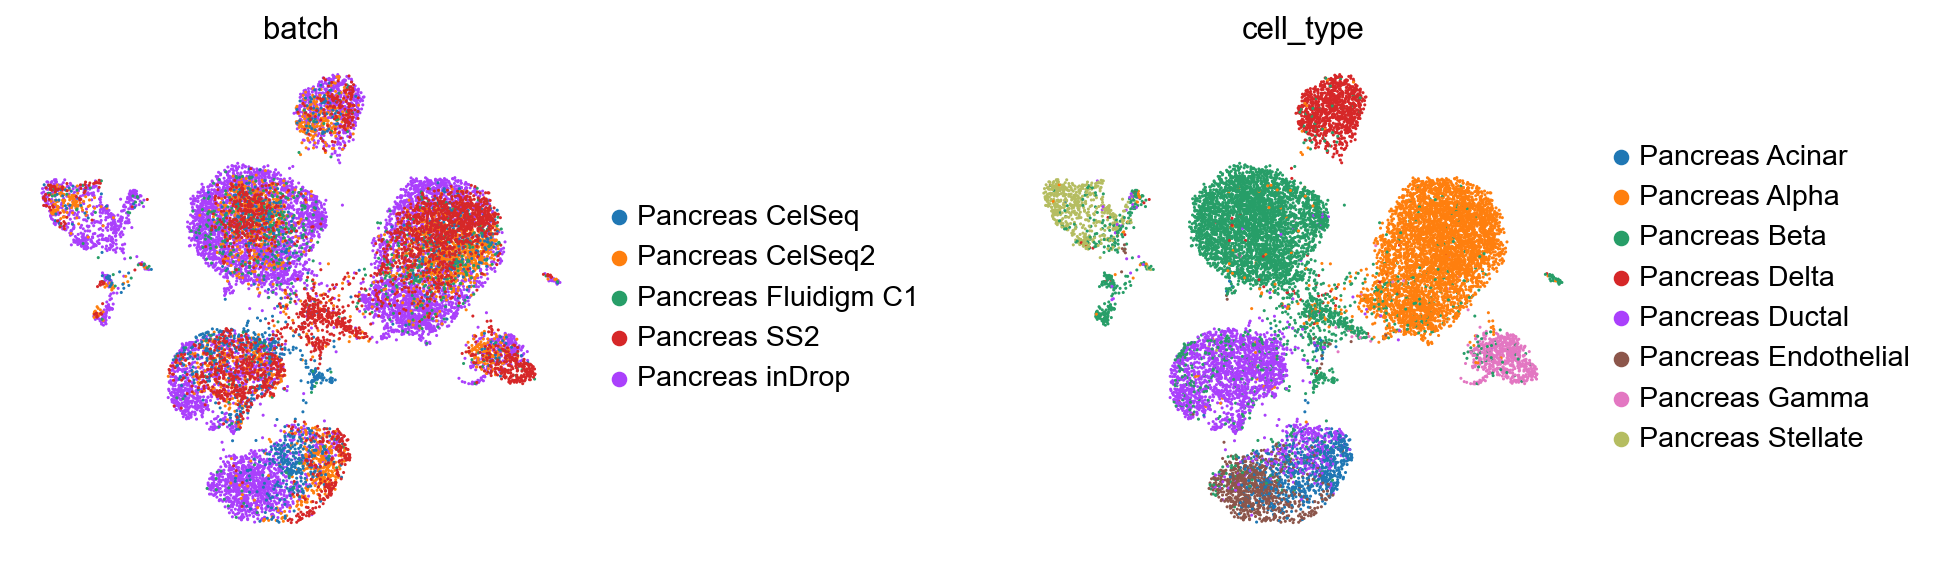

In [22]:
sc.pp.neighbors(full_latent, n_neighbors=8)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
sc.pl.umap(full_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )